# 1. Library

In [ ]:
# RoS related message
from ros_data_reader import Vector_set

In [3]:
import os
import torch

import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import sklearn.preprocessing
#from directory_tree import display_tree
# Customed Library
import engine ,model_builder,utils
import data_loader
import numpy as np
#import torchinfo
from timeit import default_timer as timer 

#display_tree('./')

ModuleNotFoundError: No module named 'sensor_msgs'

# 2. Data loading

In [2]:
path='./rosbag_dir'
Desired_param=[[0],[0],[0],[0],[0,1,2]]
A=data_loader.data_loader(path,Desired_param)
A.file_searching(path)
list_file=A.desired_file_path(Desired_param)
Columns=['Force_X','Force_Y','Force_Z','Torque_X','Torque_Y','Torque_Z',
         'Sensor_P_1_1','Sensor_P_1_2','Sensor_P_2_1','Sensor_P_2_2',
         'Sensor_P_3_1','Sensor_P_3_2','Sensor_P_4_1','Sensor_P_4_2',
         'Sensor_P_5_1','Sensor_P_5_2','Sensor_P_6_1','Sensor_P_6_2',
         'Sensor_P_7_1','Sensor_P_7_2',
         'Sensor_S']
New_Columns=['Par1','Par2','Par3','Par4','Par5']
Total_dataset=A.read_Data_pandas(Columns,New_Columns)
Total_dataset

NameError: name 'data_loader' is not defined

### 3-1. FIltering

In [3]:
## Data filtering
# https://builtin.com/data-science/pandas-filter
Filtered_dataset=Total_dataset.query('Par5=="v1" and Force_X>0')
Filtered_dataset


,Force_X,Force_Y,Force_Z,Torque_X,Torque_Y,Torque_Z,Sensor_P_1_1,Sensor_P_1_2,Sensor_P_2_1,Sensor_P_2_2,...,Sensor_P_6_1,Sensor_P_6_2,Sensor_P_7_1,Sensor_P_7_2,Sensor_S,Par1,Par2,Par3,Par4,Par5
17690,0.000827,0.003789,0.026325,0.000052,-0.000083,-0.000425,0.00,0.00,3.675,7.516,...,7.565,8.179,10.208,5.681,14.974,test,26,05,23,v1
17691,0.000827,0.003789,0.026325,0.000052,-0.000083,-0.000425,0.00,0.00,3.675,7.516,...,7.565,8.179,10.208,5.681,14.974,test,26,05,23,v1
17692,0.000827,0.003789,0.026325,0.000052,-0.000083,-0.000425,0.00,0.00,3.675,7.516,...,7.565,8.179,10.208,5.681,14.974,test,26,05,23,v1
17693,0.000827,0.003789,0.026325,0.000052,-0.000083,-0.000425,0.00,0.00,3.675,7.516,...,7.565,8.179,10.208,5.681,14.974,test,26,05,23,v1
17694,0.000827,0.003789,0.026325,0.000052,-0.000083,-0.000425,0.00,0.00,3.675,7.516,...,7.565,8.179,10.208,5.681,14.974,test,26,05,23,v1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20835,0.000048,0.017580,0.035686,0.000342,-0.000061,-0.000371,0.29,1.56,3.675,7.521,...,7.563,8.174,10.192,5.672,14.974,test,26,05,23,v1
20836,0.000048,0.017580,0.035686,0.000342,-0.000061,-0.000371,0.29,2.23,3.675,7.521,...,7.563,8.174,10.192,5.672,14.974,test,26,05,23,v1
20837,0.000048,0.017580,0.035686,0.000342,-0.000061,-0.000371,0.29,2.23,3.675,7.521,...,7.563,8.174,10.192,5.672,14.974,test,26,05,23,v1
20838,0.000048,0.017580,0.035686,0.000342,-0.000061,-0.000371,0.29,2.23,3.675,7.521,...,7.563,8.174,10.192,5.672,14.974,test,26,05,23,v1


### 3-2 Combination of the data

In [1]:
Total_col=[*Columns,*New_Columns]
for i in range(len(Total_col)):
    if i==0:
        print(f'{"Total column" :^120}')
        print('')
    print(f'{i:<} {Total_col[i] : <30}   ',end='')
    if i%3 ==0 and i!=0:
        print('')
        

Desired_combination_COL=[*Total_col[0:3],*Total_col[-9:-5]] ####################### chose the combination of the col
print('')
for i in range(len(Desired_combination_COL)):
    if i==0:
        print(f'{"Desired_combination_COL" :^120}')
        print('')
    print(f'{i:<} {Desired_combination_COL[i] : <30}   ',end='')
    if i%3 ==0 and i!=0:
        print('')


Desired_combination_COL
Combi_df=Filtered_dataset.filter(items=Desired_combination_COL)

NameError: name 'Columns' is not defined

### 3. Save the file into pickle format

In [5]:
save_mode= True

if save_mode== True:
    Combi_df.to_pickle("./pickle/test_1.pkl") 

# 3.Start

### 3-1. Data loading and preparation
1) Read pickle
2) Divide Input and output && Train and test set
3) To Tensor
4) Normalization
5) Batch size

In [5]:
Combi_df = pd.read_pickle("./pickle/test_1.pkl")  


# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"


# Hot encoding needed
# Scailing!
# Validation dataset?

Y=np.array(Combi_df.filter(items=Desired_combination_COL[0:1]))
X=np.array(Combi_df.filter(items=Desired_combination_COL[3:]))

# Scaler
X_scaler = sklearn.preprocessing.MinMaxScaler()
Y_scaler = sklearn.preprocessing.MinMaxScaler()

X=torch.FloatTensor(X_scaler.fit_transform(X))
Y=torch.FloatTensor(Y_scaler.fit_transform(Y))



X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible


train_dataset=DataLoader(data_loader.Data(X_train,Y_train),batch_size=BATCH_SIZE)
test_dataset=DataLoader(data_loader.Data(X_test,Y_test),batch_size=BATCH_SIZE)
Input_dim=len(X_train[0])
Output_dim=len(Y_train[0])

print(f'{"Input dim ":>20}{Input_dim}{"||":^22}{"Output dim ":>20}{Output_dim}')
print(f'Input Train: {len(X_train)},Test: {len(X_test)}   ||   Output Train: {len(Y_train)}, Test: {len(Y_test)}')

NameError: name 'np' is not defined

### 3-2. Set hypermeter
1. Epochs
2. Batch size
3. Learning rate
4. Device 
5. Activation function
6. Loss function
7. Optimizer

In [4]:

# Model

model = model_builder.LSTMModel(
    input_dim = Input_dim,
    hidden_dim=HIDDEN_UNITS,
    layer_dim=2,
    output_dim=Output_dim,
    dropout_prob=0.7)


# Set loss and optimizer
loss_fn = torch.nn.MSELoss() ## change
optimizer = torch.optim.Adam(model.parameters(), ## change
                             lr=LEARNING_RATE)


NameError: name 'Input_dim' is not defined

### 3-3. Model


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0364 | train_acc: 0.1386 | test_loss: 0.0213 | test_acc: 0.2500
Epoch: 2 | train_loss: 0.0362 | train_acc: 0.1232 | test_loss: 0.0210 | test_acc: 0.0677
Epoch: 3 | train_loss: 0.0357 | train_acc: 0.1096 | test_loss: 0.0209 | test_acc: 0.0833
Epoch: 4 | train_loss: 0.0352 | train_acc: 0.1300 | test_loss: 0.0209 | test_acc: 0.2552
Epoch: 5 | train_loss: 0.0354 | train_acc: 0.1544 | test_loss: 0.0209 | test_acc: 0.3021
Total training time: 0.099 seconds


TypeError: can only concatenate str (not "int") to str

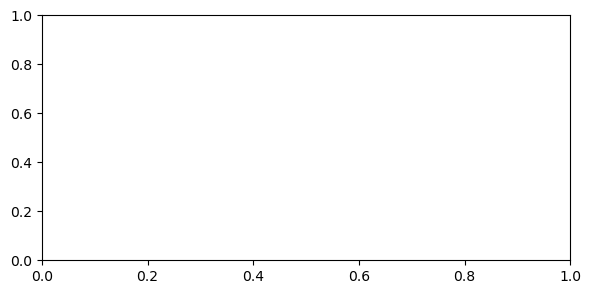

In [11]:

#torchinfo.summary(model,(5,5,5))
start_time = timer()
results=engine.train(model=model,
             train_dataloader=train_dataset,
             test_dataloader=test_dataset,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
utils.plot_loss_curves([results])

### 3-4 Compare the results and save

In [10]:

results


{'train_loss': [0.0555590341353546,
  0.0453359468475632,
  0.04060288804137836,
  0.03824355520065064,
  0.03727536850973316],
 'train_acc': [0.3645833333333333,
  0.2821557971014493,
  0.19972826086956522,
  0.1480978260869565,
  0.14673913043478262],
 'test_loss': [0.033040914529313646,
  0.026564101067682106,
  0.023728286769861977,
  0.022340329946018755,
  0.021661792416125536],
 'test_acc': [0.5, 0.5, 0.4427083333333333, 0.23958333333333334, 0.28125]}